In [110]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import statsmodels.api as sm
from scipy.stats import jarque_bera
from scipy.stats import normaltest

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

# I want to read the full contents of each sentiment
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

## Functions

In [111]:
def quick_histogram(series,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
    plt.hist(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [112]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

#house_df.head(10)

## Data cleaning

In [113]:
# Filling in missing values with 0s, or "NA"
house_df['lotfrontage'].fillna(0,inplace=True)
house_df['masvnrtype'].fillna("NA",inplace=True)
house_df['masvnrarea'].fillna(0.0,inplace=True)
house_df['bsmtqual'].fillna("NA",inplace=True) 
house_df['bsmtcond'].fillna("NA",inplace=True) 
house_df['bsmtfintype1'].fillna("NA",inplace=True) 
house_df['bsmtexposure'].fillna("NA",inplace=True) 
house_df['bsmtfintype2'].fillna("NA",inplace=True) 
house_df['fireplacequ'].fillna("NA",inplace=True)
house_df['garagetype'].fillna("NA",inplace=True) 
house_df['garageyrblt'].fillna("NA",inplace=True) 
house_df['garagefinish'].fillna("NA",inplace=True) 
house_df['garagequal'].fillna("NA",inplace=True) 
house_df['garagecond'].fillna("NA",inplace=True)

In [114]:
# Dropping poorly populated or irrelevant variables
house_df.drop(columns=['id','alley','electrical','poolqc','fence','miscfeature'],inplace=True)

## Feature engineering / setup training data for the model

In [115]:
house_df['log_lotarea'] = np.log(house_df['lotarea'])

In [116]:
house_df['has_porch'] = ((house_df['openporchsf'] > 0) | (house_df['enclosedporch'] > 0) | (house_df['threessnporch'] > 0) | (house_df['screenporch'] > 0)).map({True: 1, False: 0})
house_df['has_deck'] = (house_df['wooddecksf'] > 0).map({True: 1, False: 0})

In [117]:
# Start with these features of interest. 
vars_of_interest = ['saleprice','log_lotarea','neighborhood','bldgtype','housestyle','yearbuilt',
                    'grlivarea','garagearea','has_deck','has_porch']

house_interest_df = house_df[vars_of_interest]
house_interest_df.head()

,saleprice,log_lotarea,neighborhood,bldgtype,housestyle,yearbuilt,grlivarea,garagearea,has_deck,has_porch
0,208500,9.041922,CollgCr,1Fam,2Story,2003,1710,548,0,1
1,181500,9.169518,Veenker,1Fam,1Story,1976,1262,460,1,0
2,223500,9.328123,CollgCr,1Fam,2Story,2001,1786,608,0,1
3,140000,9.164296,Crawfor,1Fam,2Story,1915,1717,642,0,1
4,250000,9.565214,NoRidge,1Fam,2Story,2000,2198,836,1,1


In [118]:
# Append one-hot versions of neighborhoods and house style to the dataframe of interesting variables
house_interest_df = pd.concat([house_interest_df, pd.get_dummies(house_df['neighborhood'],drop_first=True)], axis=1)
house_interest_df = pd.concat([house_interest_df, pd.get_dummies(house_df['housestyle'],drop_first=True)], axis=1)
house_interest_df.head()

,saleprice,log_lotarea,neighborhood,bldgtype,housestyle,yearbuilt,grlivarea,garagearea,has_deck,has_porch,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl
0,208500,9.041922,CollgCr,1Fam,2Story,2003,1710,548,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,181500,9.169518,Veenker,1Fam,1Story,1976,1262,460,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,223500,9.328123,CollgCr,1Fam,2Story,2001,1786,608,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,140000,9.164296,Crawfor,1Fam,2Story,1915,1717,642,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,250000,9.565214,NoRidge,1Fam,2Story,2000,2198,836,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Of all of the available variables of interest, and one-hot versions of categorical variables, the following list represents the features we previously determined to be significant. Let's train our model.

In [119]:
hidf_features = ['log_lotarea','yearbuilt','grlivarea','garagearea','has_deck','has_porch',
                  'Crawfor','Edwards','Gilbert',
                  'Mitchel','NAmes','NWAmes','NoRidge','NridgHt','Sawyer',
                  'SawyerW','StoneBr','1.5Unf','1Story',
                  'SFoyer','SLvl']

In [120]:
# Y is the target variable
Y = house_interest_df['saleprice'].values.reshape(-1,1)
# X is the feature set. I hope I didn't choose too many features...?
X = house_interest_df[hidf_features]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [[ 2.24092042e+04  7.39106951e+02  7.30409083e+01  3.64481068e+01
   6.75246637e+03  7.86968712e+03  3.29190853e+04 -2.48445059e+04
  -1.78207647e+04 -2.60012927e+04 -1.56290807e+04 -1.97042919e+04
   4.96622948e+04  6.16124510e+04 -2.09355439e+04 -1.86272582e+04
   7.07418090e+04  2.86889813e+04  1.84998849e+04  2.44522166e+04
   1.59788979e+04]]

Intercept: 
 [-1625851.54407805]


__I took out the code that generates this summary, because it messed with X. But this is the summary that was generated immediately after fitting the model above:__
```
OLS Regression Results
Dep. Variable:	y	R-squared:	0.786
Model:	OLS	Adj. R-squared:	0.783
Method:	Least Squares	F-statistic:	251.4
Date:	Thu, 25 Jul 2019	Prob (F-statistic):	0.00
Time:	14:15:17	Log-Likelihood:	-17419.
No. Observations:	1460	AIC:	3.488e+04
Df Residuals:	1438	BIC:	3.500e+04
Df Model:	21		
Covariance Type:	nonrobust		
coef	std err	t	P>|t|	[0.025	0.975]
const	-1.626e+06	8.97e+04	-18.135	0.000	-1.8e+06	-1.45e+06
log_lotarea	2.241e+04	2309.384	9.704	0.000	1.79e+04	2.69e+04
yearbuilt	739.1070	43.238	17.094	0.000	654.291	823.923
grlivarea	73.0409	2.965	24.631	0.000	67.224	78.858
garagearea	36.4481	6.217	5.863	0.000	24.253	48.643
has_deck	6752.4664	2094.064	3.225	0.001	2644.719	1.09e+04
has_porch	7869.6871	2246.985	3.502	0.000	3461.967	1.23e+04
Crawfor	3.292e+04	5585.209	5.894	0.000	2.2e+04	4.39e+04
Edwards	-2.484e+04	4140.414	-6.000	0.000	-3.3e+04	-1.67e+04
Gilbert	-1.782e+04	4819.679	-3.698	0.000	-2.73e+04	-8366.409
Mitchel	-2.6e+04	5666.666	-4.588	0.000	-3.71e+04	-1.49e+04
NAmes	-1.563e+04	3118.930	-5.011	0.000	-2.17e+04	-9510.941
NWAmes	-1.97e+04	4710.222	-4.183	0.000	-2.89e+04	-1.05e+04
NoRidge	4.966e+04	6426.362	7.728	0.000	3.71e+04	6.23e+04
NridgHt	6.161e+04	4843.629	12.720	0.000	5.21e+04	7.11e+04
Sawyer	-2.094e+04	4753.018	-4.405	0.000	-3.03e+04	-1.16e+04
SawyerW	-1.863e+04	5149.311	-3.617	0.000	-2.87e+04	-8526.293
StoneBr	7.074e+04	7735.931	9.145	0.000	5.56e+04	8.59e+04
1.5Unf	2.869e+04	1.03e+04	2.790	0.005	8516.678	4.89e+04
1Story	1.85e+04	2717.072	6.809	0.000	1.32e+04	2.38e+04
SFoyer	2.445e+04	6779.287	3.607	0.000	1.12e+04	3.78e+04
SLvl	1.598e+04	5172.149	3.089	0.002	5833.132	2.61e+04
Omnibus:	362.785	Durbin-Watson:	1.967
Prob(Omnibus):	0.000	Jarque-Bera (JB):	20841.573
Skew:	0.097	Prob(JB):	0.00
Kurtosis:	21.508	Cond. No.	2.36e+05
```

## Checking assumptions
### Assumption one: linearity of the model in its coefficients

In [121]:
predictions = lrm.predict(X)
predictions

array([[209945.15113325],
       [174301.50680155],
       [222618.48470905],
       ...,
       [233784.15375277],
       [126138.68314545],
       [142824.97832639]])

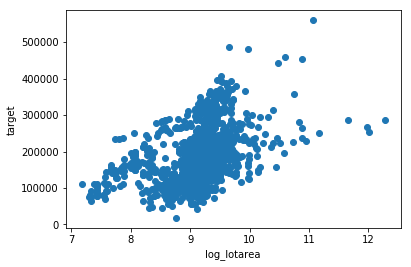

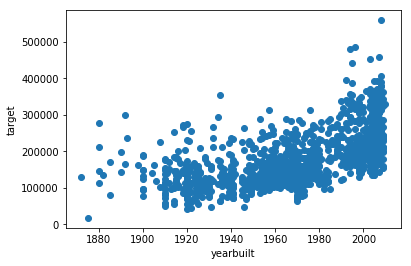

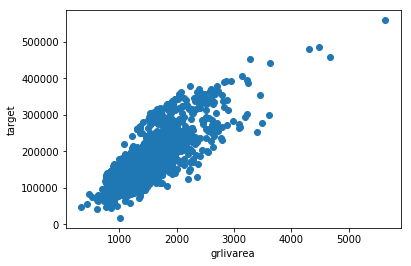

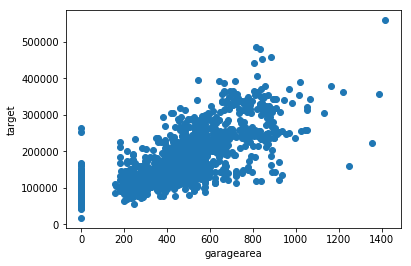

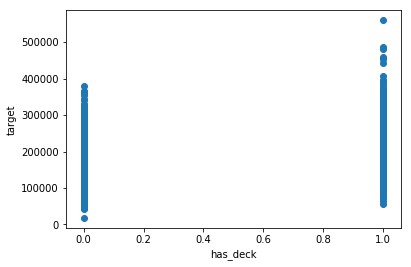

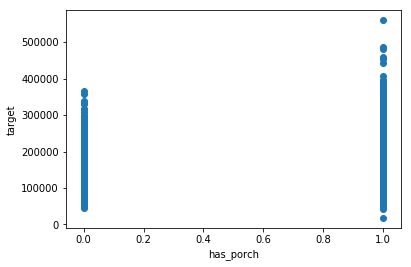

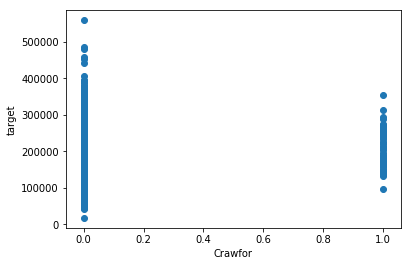

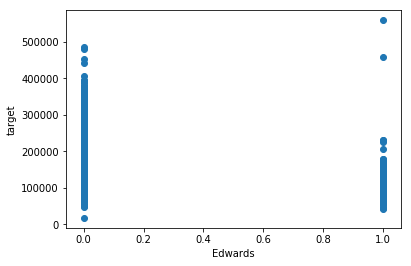

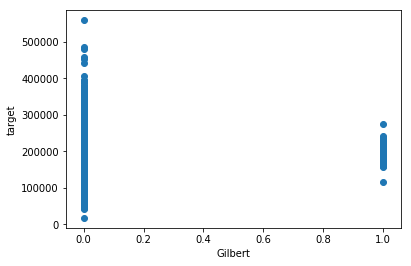

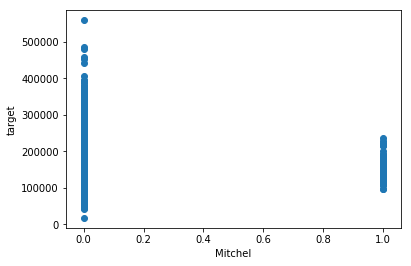

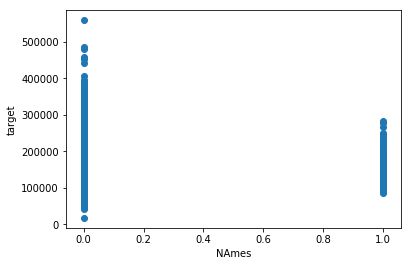

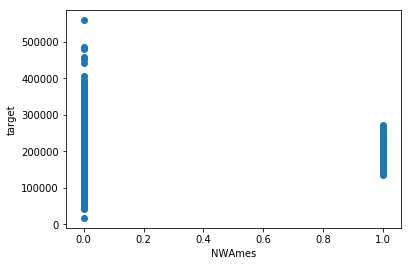

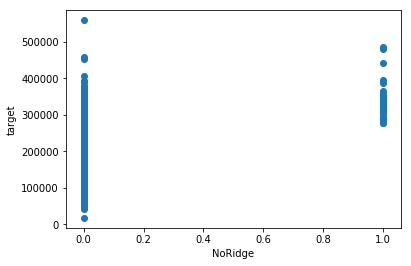

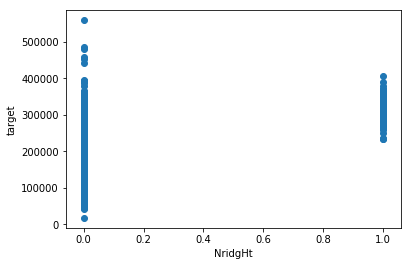

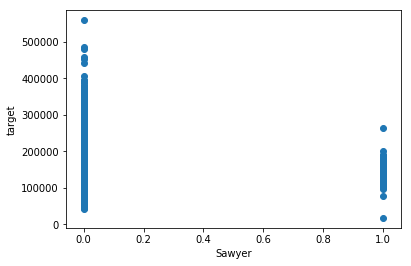

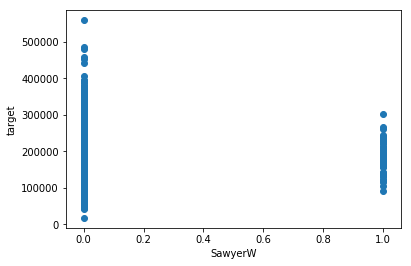

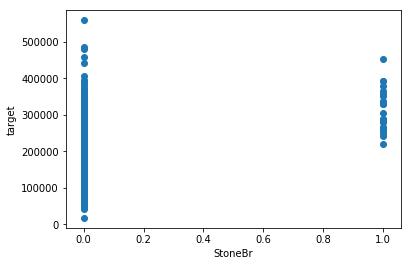

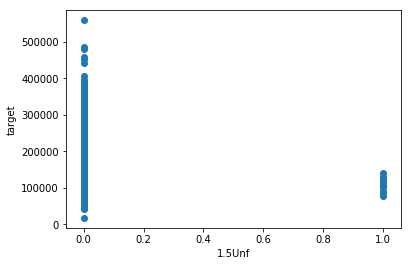

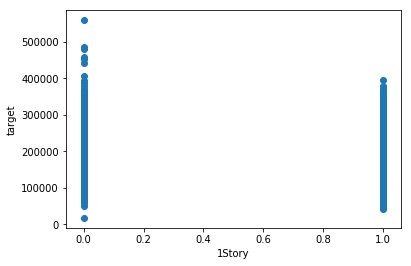

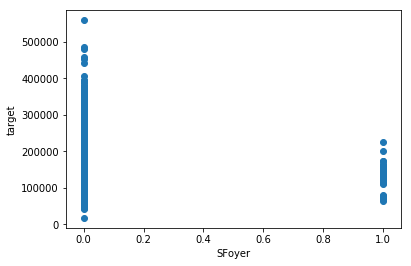

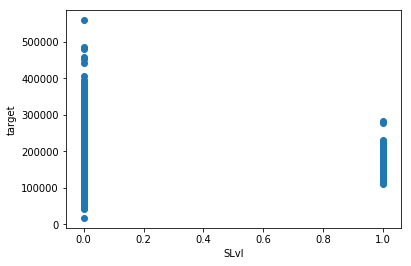

In [122]:
# We plot the estimated Y, and X features
for xfeature in hidf_features:
    plt.scatter(X[xfeature], predictions)
    plt.xlabel(xfeature)
    plt.ylabel("target")
    plt.title('')
    plt.show()

I don't see anything in these plots that would suggest anything besides a linear relationship between the coefficients and the target variable. I think this assumption is good...?

## Assumption two: the error term should be zero on average

Our model has a constant, so this assumption is good.

`-1625851.54407805`

## Assumption three: homoscedasticity

In [123]:
errors = Y - predictions
errors.shape

(1460, 1)

In [124]:
flat_errors = np.ndarray.flatten(errors)
flat_errors

array([-1445.15113325,  7198.49319845,   881.51529095, ...,
       32715.84624723, 15986.31685455,  4675.02167361])

In [125]:
flat_predictions = np.ndarray.flatten(predictions)
flat_predictions

array([209945.15113325, 174301.50680155, 222618.48470905, ...,
       233784.15375277, 126138.68314545, 142824.97832639])

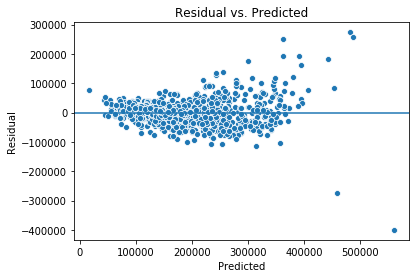

In [126]:
sns.scatterplot(flat_predictions,flat_errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [127]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(flat_predictions, flat_errors)
lev_stats = levene(flat_predictions, flat_errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 577.523 and p value is 1.3e-127
Levene test statistic value is 480.999 and p value is 8.15e-99


__The p-values of both tests are lower than 0.05--the test results reject the null hypothesis of these tests, which means our errors are heteroscedastic.__

I feel like we already reached the optimal number of features--I removed a bunch because they were not significant and hurt our adjusted R-squared value when I generated stats for the model.

Our other option is to try transforming the dependent variable. Maybe a log transformation would help here?

Text(0.5, 0.98, 'Raw and log transformed sale price')

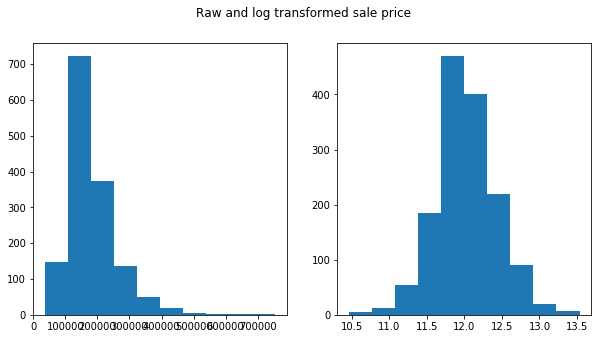

In [128]:
# Tried Box-Cox, but it looked terrible. So let's try a log transformation instead.
#from scipy.stats import boxcox 

fig=plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(house_df['saleprice'])

plt.subplot(1,2,2)
plt.hist(np.log(house_df['saleprice']))
plt.suptitle("Raw and log transformed sale price")

In [129]:
# Y is the target variable
Y = np.log(house_interest_df['saleprice']).values.reshape(-1,1)
# X is the feature set. I hope I didn't choose too many features...?
X = house_interest_df[hidf_features]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [[ 1.21321684e-01  4.97712185e-03  3.32994965e-04  2.39082311e-04
   4.80031559e-02  7.41964425e-02  2.48168039e-01 -1.39513331e-01
  -6.85667394e-02 -9.90674790e-02 -2.72230564e-02 -3.36484312e-02
   8.78471693e-02  1.76004242e-01 -6.76689305e-02 -7.59169389e-02
   2.36820900e-01  8.26691400e-02  5.12356183e-02  6.63867929e-02
   7.42781350e-02]]

Intercept: 
 [0.38907543]


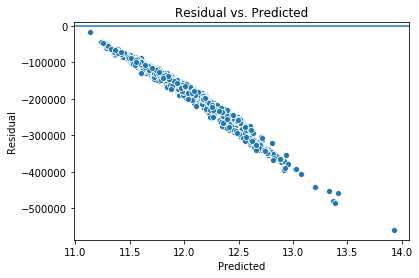

In [130]:
errors = Y - predictions
flat_errors = np.ndarray.flatten(errors)
predictions = lrm.predict(X)
flat_predictions = np.ndarray.flatten(predictions)

sns.scatterplot(flat_predictions,flat_errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [131]:
bart_stats = bartlett(flat_predictions, flat_errors)
lev_stats = levene(flat_predictions, flat_errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 33533.4 and p value is 0
Levene test statistic value is 2035.52 and p value is 0


Okay, still no good. Are outliers of the dependent variable killing us?

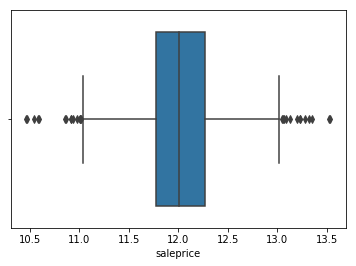

In [132]:
sns.boxplot(np.log(house_df['saleprice']),data=house_df)

In [133]:
from scipy.stats.mstats import winsorize
Y_winz = winsorize(np.log(house_df['saleprice']),(.02,.02))

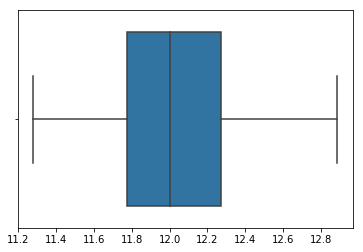

In [134]:
sns.boxplot(Y_winz)

In [135]:
# Y is the target variable
Y = Y_winz.reshape(-1,1)
# X is the feature set. I hope I didn't choose too many features...?
X = house_interest_df[hidf_features]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [[ 1.24751774e-01  4.81670522e-03  2.97915258e-04  2.16384105e-04
   4.47175471e-02  7.16905373e-02  2.40029027e-01 -1.51187859e-01
  -7.11582141e-02 -1.13042914e-01 -4.69662351e-02 -3.49376361e-02
   6.97337001e-02  1.64282259e-01 -8.69597814e-02 -7.76879658e-02
   2.09443392e-01  4.37252629e-02  4.76443700e-02  4.65148600e-02
   6.77751289e-02]]

Intercept: 
 [0.75369746]


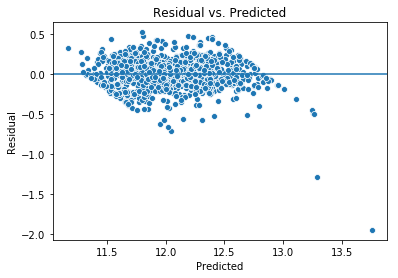

In [136]:
errors = Y - predictions
flat_errors = np.ndarray.flatten(errors)
predictions = lrm.predict(X)
flat_predictions = np.ndarray.flatten(predictions)

sns.scatterplot(flat_predictions,flat_errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [137]:
bart_stats = bartlett(flat_predictions, flat_errors)
lev_stats = levene(flat_predictions, flat_errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 720.655 and p value is 9.64e-159
Levene test statistic value is 716.585 and p value is 2.38e-141


These results still suggest a variance that is not constant, though my mentor confirmed the steps I took are correct and the transformations looked good. I'm going to move on...

## Assumption four: low multicollinearity

In [138]:
X

,log_lotarea,yearbuilt,grlivarea,garagearea,has_deck,has_porch,Crawfor,Edwards,Gilbert,Mitchel,NAmes,NWAmes,NoRidge,NridgHt,Sawyer,SawyerW,StoneBr,1.5Unf,1Story,SFoyer,SLvl
0,9.041922,2003,1710,548,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9.169518,1976,1262,460,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,9.328123,2001,1786,608,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9.164296,1915,1717,642,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9.565214,2000,2198,836,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5,9.554993,1993,1362,480,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,9.218705,2004,1694,636,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7,9.247829,1973,2090,484,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,8.719317,1931,1774,468,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,8.911934,1939,1077,205,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


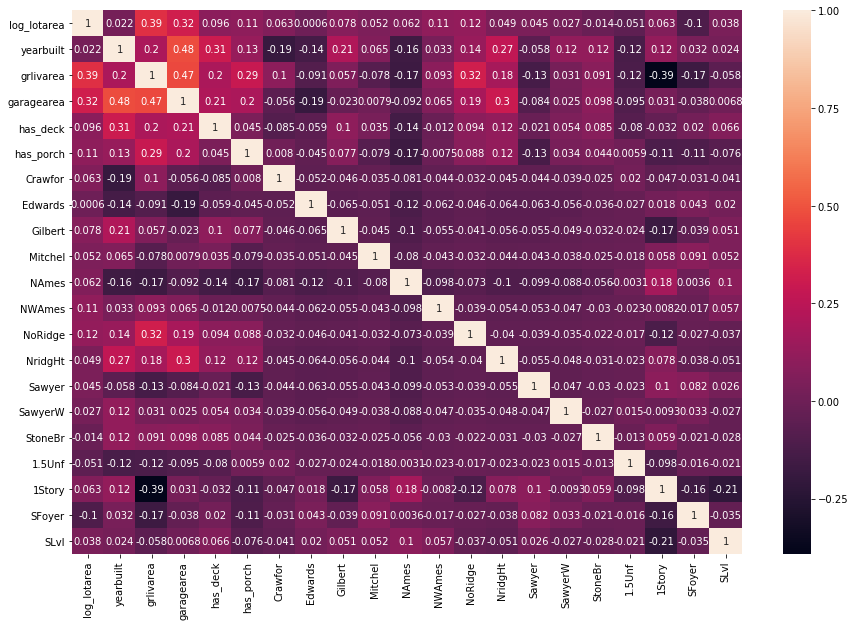

In [139]:
house_corr = X.corr()
# We can check out a heatmap to see the correlation between our independent features
plt.figure(figsize=(15,10))
sns.heatmap(house_corr, annot=True)

OHHH. Year Built, Above-Ground Living Area, and Garage Area (sq. ft.) are tied to each other to some degree. What if I remove one of them and retry?

But first, how does the distribution of our errors look? (This answers a question I have in the sixth assumption, below.)

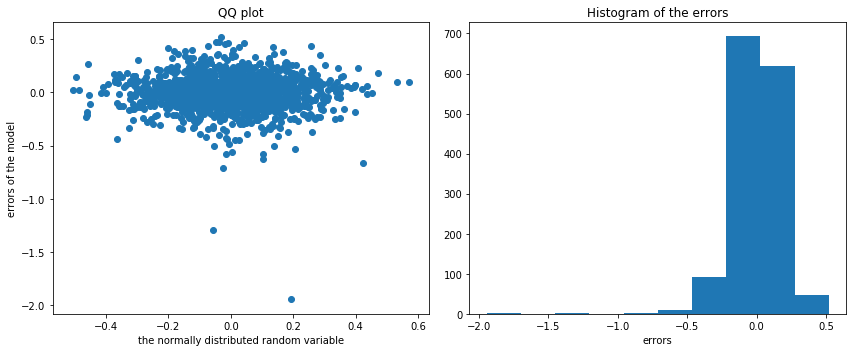

In [140]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

### Let's try removing yearbuilt and garagearea, and see how things look.

In [141]:
hidf_features = ['log_lotarea','grlivarea','has_deck','has_porch',
                  'Edwards',
                  'Mitchel','NAmes','NWAmes','NoRidge','NridgHt','Sawyer',
                  'StoneBr','1Story',
                  'SFoyer','SLvl']
# Also removed Crawfor, Gilbert, SawyerW, 1.5Unf 
# because they became less significant after removing yearbuilt and garagearea

In [142]:
# Y is the target variable
Y = house_interest_df['saleprice'].values.reshape(-1,1)
# X is the feature set. 
X = house_interest_df[hidf_features]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [[ 18680.83983709     89.99937639  14022.97730572  11119.82903508
  -38968.97115919 -19255.06119639 -24451.81656656 -17052.98428555
   65261.32387376  86348.63948998 -28388.97042359  84730.37325532
   36255.33313726  47761.20414998  32653.035672  ]]

Intercept: 
 [-159167.85728162]


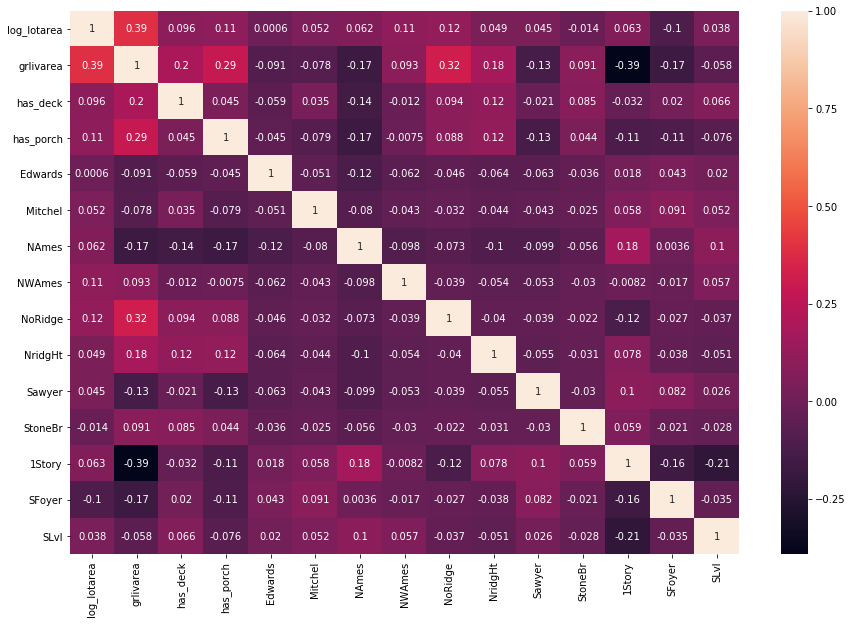

In [143]:
house_corr = X.corr()
# We can check out a heatmap to see the correlation between our independent features
plt.figure(figsize=(15,10))
sns.heatmap(house_corr, annot=True)

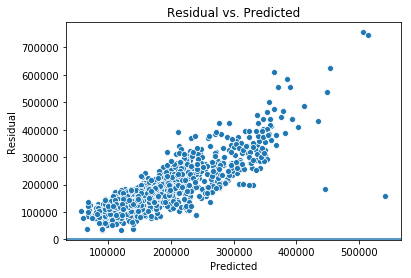

In [144]:
errors = Y - predictions
flat_errors = np.ndarray.flatten(errors)
predictions = lrm.predict(X)
flat_predictions = np.ndarray.flatten(predictions)

sns.scatterplot(flat_predictions,flat_errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Still a few outliers, but this looks great otherwise.

In [145]:
# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     242.3
Date:                Thu, 25 Jul 2019   Prob (F-statistic):               0.00
Time:                        14:34:55   Log-Likelihood:                -17626.
No. Observations:                1460   AIC:                         3.528e+04
Df Residuals:                    1444   BIC:                         3.537e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.592e+05   2.09e+04     -7.627      0.000      -2e+05   -1.18e+05
log_lotarea  1.868e+04   2520.065      7.413      0.000    1.37e+04    2.36e+04
grlivarea      89.9994      3.094     29.084      0.000      83.929      96.070
has_deck     1.402e+04   2339.479      5.994      0.000    9433.836    1.86e+04
has_porch    1.112e+04   2572.176      4.323      0.000    6074.228    1.62e+04
Edwards     -3.897e+04   4583.465     -8.502      0.000    -4.8e+04      -3e+04
Mitchel     -1.926e+04   6427.235     -2.996      0.003   -3.19e+04   -6647.344
NAmes       -2.445e+04   3454.933     -7.077      0.000   -3.12e+04   -1.77e+04
NWAmes      -1.705e+04   5314.426     -3.209      0.001   -2.75e+04   -6628.162
NoRidge      6.526e+04   7234.584      9.021      0.000    5.11e+04    7.95e+04
NridgHt      8.635e+04   5311.549     16.257      0.000    7.59e+04    9.68e+04
Sawyer      -2.839e+04   5371.307     -5.285      0.000   -3.89e+04   -1.79e+04
StoneBr      8.473e+04   8817.342      9.610      0.000    6.74e+04    1.02e+05
1Story       3.626e+04   2859.195     12.680      0.000    3.06e+04    4.19e+04
SFoyer       4.776e+04   7621.364      6.267      0.000    3.28e+04    6.27e+04
SLvl         3.265e+04   5851.906      5.580      0.000    2.12e+04    4.41e+04
==============================================================================
Omnibus:                      244.932   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4540.943
Skew:                          -0.054   Prob(JB):                         0.00
Kurtosis:                      11.639   Cond. No.                     3.03e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After removing six variables, our R-squared stats and F-statistic have all dropped slightly. I see there is still some correlation between Lot Area and Above Ground Living Area, but they both seem necessary, describing different aspects of the properties for sale.

## Assumption five: error terms should be uncorrelated with one another

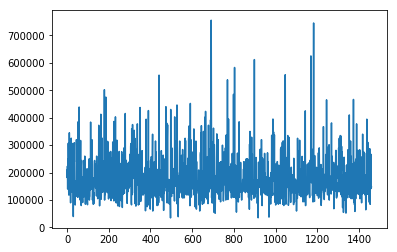

In [146]:
plt.plot(errors)
plt.show()

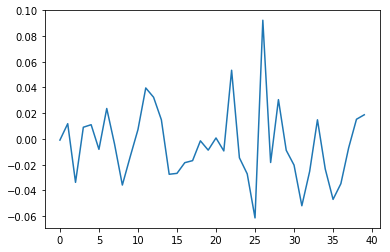

In [147]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

These two plots show no correlation, so I think we're good here.

## Assumption six: features shouldn't be correlated with the errors

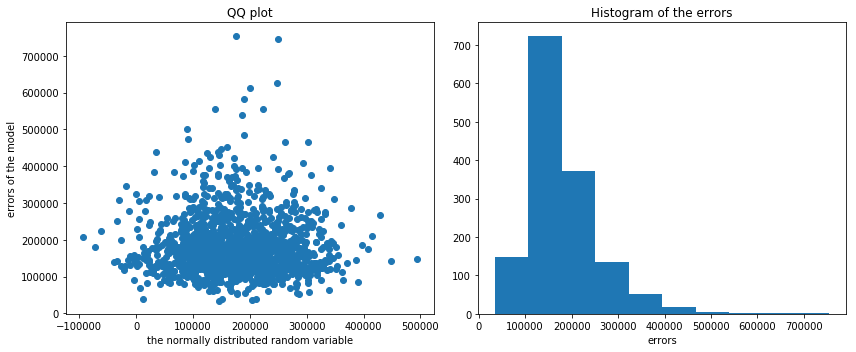

In [148]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

I'm still not totally clear--does this QQ plot, and the fact that it does not display a more or less straight line y=x, mean that there is some correlation between feature and errors?

In [149]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3438.9125345882044 and p value is 0.0
Normality test statistics is [610.83855394] and p value is [2.28083225e-133]


The histogram and the results of the Jarque-Bera and Normality tests confirm that the distribution of the errors is not normal. I want to see how these plots look if I run with the features I omitted for the rerun above. (Look above for this...)

The scale of the errors changes drastically (for the better?) if the features I removed are in place. The QQ plot still does not show the hoped-for line along y=x. The distribution looks a lot more normal than after I removed the correlated features, but is still clearly not normal.

I also considered PCA to try and eliminate the issues with multicollinearity. I bumbled through part of it, but mostly just want to keep moving ahead for now. You can see what parts of it I completed below.

In [127]:
# Try feaure selection again, using PCA this time?
#X = StandardScaler().fit_transform(house_df)
X = StandardScaler().fit_transform(house_interest_df[hidf_features])

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00068540e+00  2.19517188e-02  3.94847891e-01  3.22266206e-01
   9.64668114e-02  1.05885889e-01  6.30686206e-02  6.03404424e-04
   7.82237730e-02  5.16287182e-02  6.20164216e-02  1.09342572e-01
   1.23112752e-01  4.86861118e-02  4.48041596e-02  2.68992883e-02
  -1.42227231e-02 -5.15338241e-02  6.31589853e-02 -1.03700805e-01
   3.82246782e-02]
 [ 2.19517188e-02  1.00068540e+00  1.99146115e-01  4.79282095e-01
   3.05504105e-01  1.34478068e-01 -1.87395146e-01 -1.37485659e-01
   2.13915624e-01  6.47732386e-02 -1.59465279e-01  3.31695237e-02
   1.36174841e-01  2.69082369e-01 -5.81427634e-02  1.17608198e-01
   1.19043372e-01 -1.22935456e-01  1.23339562e-01  3.25126708e-02
   2.37294373e-02]
 [ 3.94847891e-01  1.99146115e-01  1.00068540e+00  4.69318929e-01
   1.97533527e-01  2.88708734e-01  1.00081837e-01 -9.06167844e-02
   5.73415302e-02 -7.85464438e-02 -1.66810974e-01  9.27893342e-02
   3.21669834e-01  1.80015401e-01 -1.32196733e-01  3.10995930e-02
   9.14275825e-02 

In [128]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[ 0.25816065  0.37115534  0.46270641  0.45747418  0.26915899  0.26456908
 -0.03034653 -0.13185512  0.11263961 -0.01388168 -0.1803117   0.06606292
  0.22817318  0.23887314 -0.10302723  0.05658382  0.09375607 -0.10142007
 -0.10894893 -0.08786663 -0.01017577]
Eigenvalue 1: 2.6924904811871233
----------------------------------------
Eigenvector 2: 
[ 0.23838693  0.15525248 -0.65849511  0.15386273  0.04302376  0.03102466
  0.09145467  0.05564361 -0.09614708  0.01215205  0.1000489   0.06023815
  0.08071966  0.06870101  0.04004546  0.01365267  0.07473212 -0.10768273
 -0.53954323 -0.22797509 -0.22625025]
Eigenvalue 2: 0.21611277074406657
----------------------------------------
Eigenvector 3: 
[ 0.35607482  0.48611495  0.06421069 -0.47166883 -0.0925668  -0.05948145
 -0.08451832 -0.19580372 -0.33578281 -0.17717743 -0.21879121 -0.1873597
 -0.15701656 -0.13748678 -0.17736593 -0.19823552 -0.08291422  0.00206529
 -0.05749391  0.02463474  0.02235915]
Eigenvalue 3: 0.2994689453359862


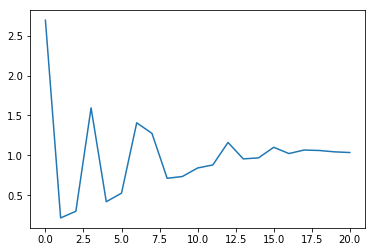

[2.69249048 0.21611277 0.29946895 1.59448825 0.41907329 0.52634184
 1.4074408  1.27527606 0.7122978  0.73510878 0.8414166  0.87981461
 1.16155643 0.95573079 0.96800506 1.10085949 1.02241061 1.06662779
 1.06077628 1.04379312 1.03530363]


In [129]:
# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.1281248  0.07577547 0.06695583 0.06055889 0.0548517 ]


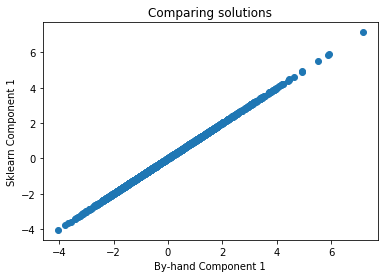

In [130]:
sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

In [131]:
# Here are the components we care about
for index, val in enumerate(eig_val_cov):
    if val > 1:
        print("Index {}: value: {}".format(index,val))

Index 0: value: 2.6924904811871233
Index 3: value: 1.5944882485078868
Index 6: value: 1.4074407990895894
Index 7: value: 1.275276056893177
Index 12: value: 1.1615564315192886
Index 15: value: 1.1008594870432966
Index 16: value: 1.022410608823955
Index 17: value: 1.066627788242851
Index 18: value: 1.060776280242776
Index 19: value: 1.0437931157620266
Index 20: value: 1.035303625481646


In [132]:
## Y is the target variable
#Y2 = house_df['saleprice']
## X is the feature set. I hope I didn't choose too many features...?
#X2 = house_df[['grlivarea','NoRidge','Somerst','Timber','2Story']]
#
## We create a LinearRegression model object
## from scikit-learn's linear_model module.
#lrm = linear_model.LinearRegression()
#
## fit method estimates the coefficients using OLS
#lrm.fit(X2, Y2)
#
## Inspect the results.
#print('\nCoefficients: \n', lrm.coef_)
#print('\nIntercept: \n', lrm.intercept_)

In [ ]:
## We need to manually add a constant
## in statsmodels' sm
#X2 = sm.add_constant(X2)
#
#results = sm.OLS(Y2, X2).fit()
#
#results.summary()